In [1]:
!pip install zennit-crp torch torchvision captum seaborn matplotlib

  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.22.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached torchvision-0.22.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached torchvision-0.21.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torchvision-0.20.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torchvision-0.20.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torchvision-0.19.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.0 kB)
  Using cached torchvision-0.19.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.0 kB)
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.2739873].


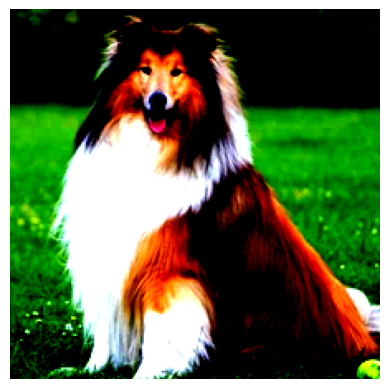

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..3.0].


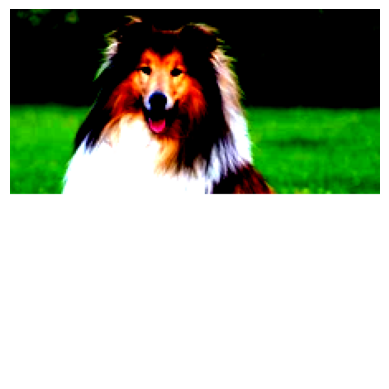

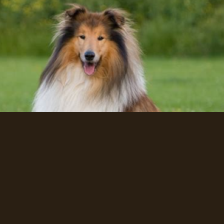

In [19]:
import torch

from torchvision.models.vision_transformer import vit_b_16
from torchvision.models.resnet import resnet50
from torchvision.models.vgg import vgg16
from torchvision.models.swin_transformer import swin_b
from torchvision.models.efficientnet import efficientnet_v2_s
# from transformers import AutoModelForImageClassification
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
# import timm

device = "cuda:0" if torch.cuda.is_available() else "cpu"


# model = vit_b_16(pretrained=True).to(device)
# model = efficientnet_v2_s(pretrained=True).to(device)
model = swin_b(pretrained=True).to(device)
# model = resnet50(pretrained=True).to(device)
#model = vgg16(pretrained=True).to(device)

transform = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

model.eval()


# image = Image.open("images/lizard.jpg")
image = Image.open("images/dog.jpeg")
sample = transform(image).unsqueeze(0).to(device)

# load the index to label mapping in "./imagenet1000_clsidx_to_labels.txt" in format
# {number: '<label>',
#  number: '<label>',}
index_to_label = {}

with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:

        line = line.replace("{", "").replace("}", "")            

        #line = line.replace(" ", "")
        #line = line.replace(",","")
        values = line.split(":")

        values[1] = values[1].replace("'", "").replace('"', "")
        index_to_label[int(values[0])] = values[1].strip("'\"")

# cambia la mitad superior de la imagen a gris
plt.imshow(sample[0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

# la mitad superior de la imagen a gris
sample[0, :, 112:] = 3  # Cambia la mitad superior a gris
#sample[0, :, :, :150] = 0.5 
plt.imshow(sample[0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
image

# ahora crea la imagen con Image .fromarray que represente a sample
# aplica la normalización inversa

sample_image = sample[0]
sample_image = (sample_image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) 
sample_image = (sample_image * 255).byte().cpu().numpy()  
sample_image = Image.fromarray(sample_image.transpose(1, 2, 0))  # Cambia el orden de los ejes para PIL

image = sample_image
image

Output  collie,
 231
Second output  Shetland sheepdog, Shetland sheep dog, Shetland,
 230
Top 10 classes:


<BarContainer object of 10 artists>

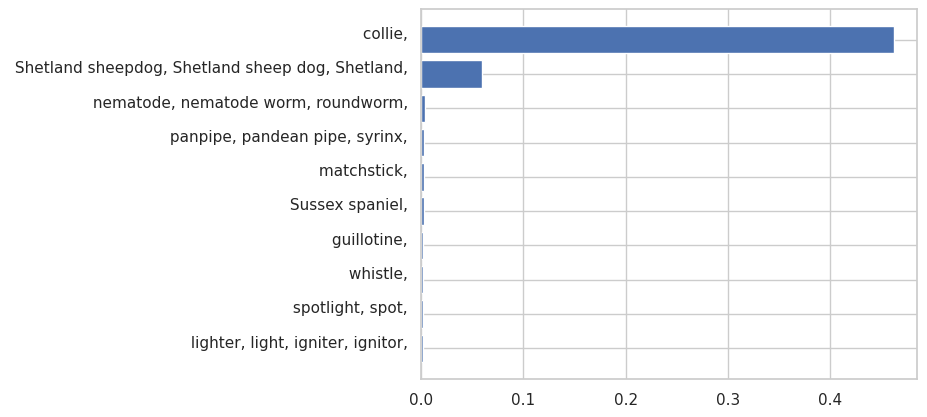

In [18]:
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution

composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)


from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)

output_class = torch.argmax(model(sample), dim=1).item()
second_output_class = torch.topk(model(sample), k=2).indices[0][1].item()

conditions1 = [{"y": range(1000)}]
conditions2 = [{"y": [output_class]}]
conditions3 = [{"y": [second_output_class]}]
print("Output", index_to_label[output_class], output_class)
print("Second output", index_to_label[second_output_class], second_output_class)
# muestra los porcentajes de las 10 clase más presentes ordenadas de mas alta a mas baja en un gráfico
print("Top 10 classes:")
output = torch.softmax(model(sample), dim=1)

top_classes = torch.topk(output, k=10)
clases = []
values = []
for i in range(10):
    clase = index_to_label[top_classes.indices[0][i].item()]
    value = top_classes.values[0][i].item()
    clases.append(clase)
    values.append(value)

plt.barh(clases[::-1], values[::-1])

In [10]:

# zennit requires gradients
sample.requires_grad = True
attr1 = attribution(sample, conditions1)
attr2 = attribution(sample, conditions2)
attr3 = attribution(sample, conditions3)

tensor(77.9388) tensor(2.0369) tensor(1.6916)


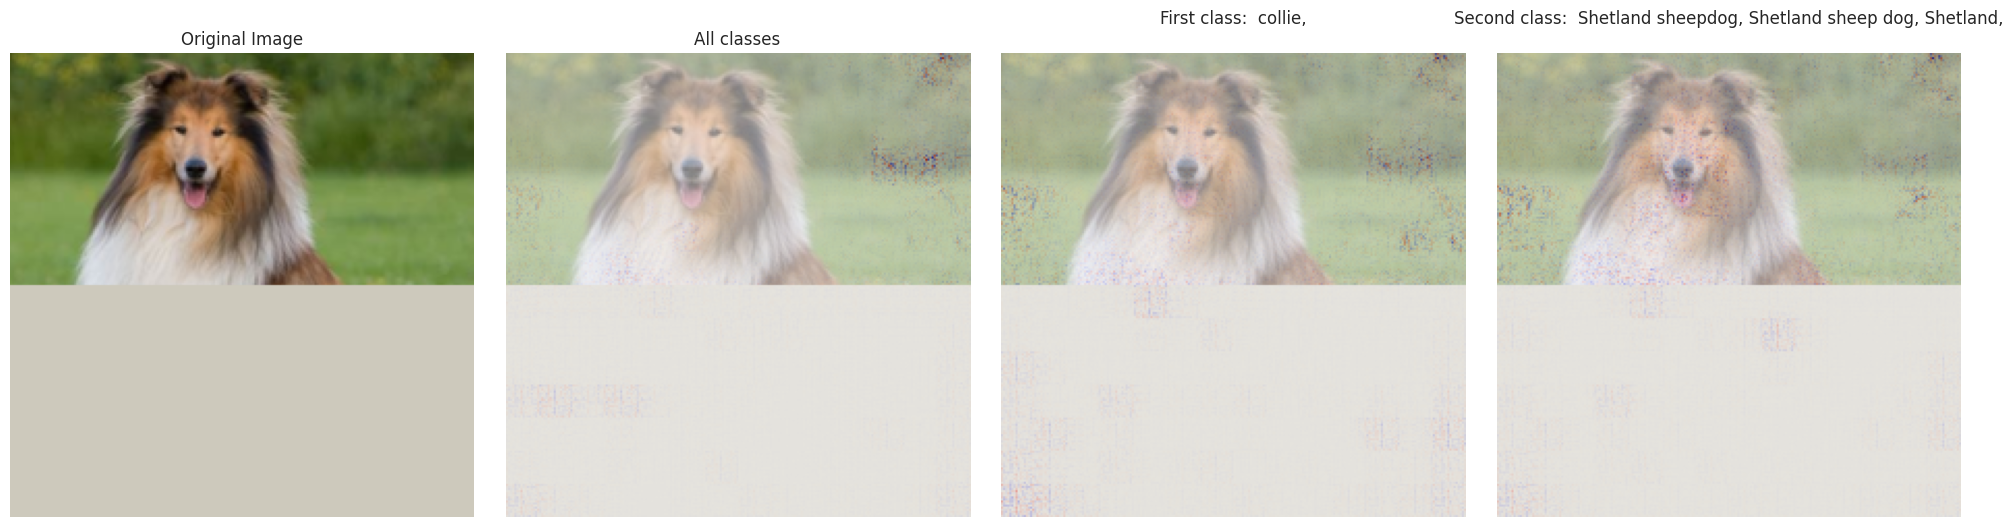

In [12]:
from crp.image import imgify


max_abs_val1 = torch.max(torch.abs(attr1.heatmap))
# resize the heatmap to the original image size
heatmap__pil1 = imgify(attr1.heatmap, vmin=-max_abs_val1, vmax=max_abs_val1)
max_abs_val2 = torch.max(torch.abs(attr2.heatmap))
heatmap__pil2 = imgify(attr2.heatmap, vmin=-max_abs_val2, vmax=max_abs_val2)
max_abs_val3 = torch.max(torch.abs(attr3.heatmap))
heatmap__pil3 = imgify(attr3.heatmap, vmin=-max_abs_val3, vmax=max_abs_val3)
print(max_abs_val1, max_abs_val2, max_abs_val3)

# Display the heatmaps in line with the original image
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(1, 4, 2)
plt.imshow(image)
heatmap__pil1 = heatmap__pil1.resize(image.size, Image.BILINEAR)
plt.imshow(heatmap__pil1, alpha=0.5, cmap='jet')
plt.title("All classes")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(image)
heatmap__pil2 = heatmap__pil2.resize(image.size, Image.BILINEAR)
plt.imshow(heatmap__pil2, alpha=0.5, cmap='jet')
plt.title("First class: " + index_to_label[output_class])
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(image)
heatmap__pil3 = heatmap__pil3.resize(image.size, Image.BILINEAR)
plt.imshow(heatmap__pil3, alpha=0.5, cmap='jet')
plt.title("Second class: " + index_to_label[second_output_class])
plt.axis('off')
plt.show()
# Save the heatmaps as images

# Study of the important features in general.

On this part, we are going to separate between the main class and the important features on the layer of features. We will check for features normals in the whole dataset and features normal, in the whole  

In [13]:
last_layer_names = get_layer_names(
    model, types=[torch.nn.Conv2d, torch.nn.Linear, torch.nn.AdaptiveAvgPool2d]
)[-3:]

print("Last layer names:", last_layer_names)
# Get the last layer's weights


conditions1 = [{"y": second_output_class}]

attr1 = attribution(sample,conditions1,composite=composite,record_layer=last_layer_names)

Last layer names: ['features.7.1.mlp.3', 'avgpool', 'head']


torch.Size([1, 7, 7, 1024]) torch.Size([1, 7, 7, 1024])
Most important feature position in features.7.1.mlp.3: 10327


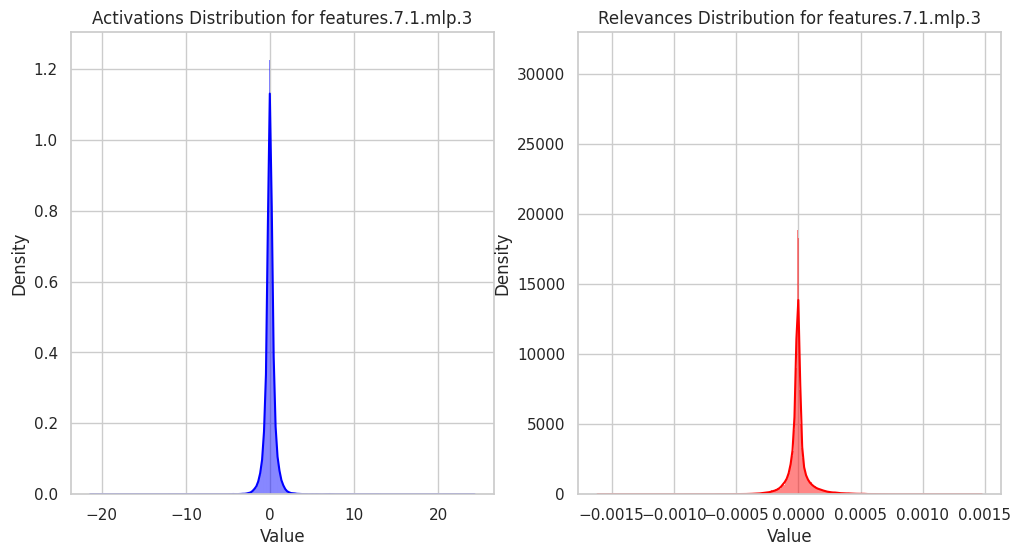

torch.Size([1, 1024, 1, 1]) torch.Size([1, 1024, 1, 1])
Most important feature position in avgpool: 158


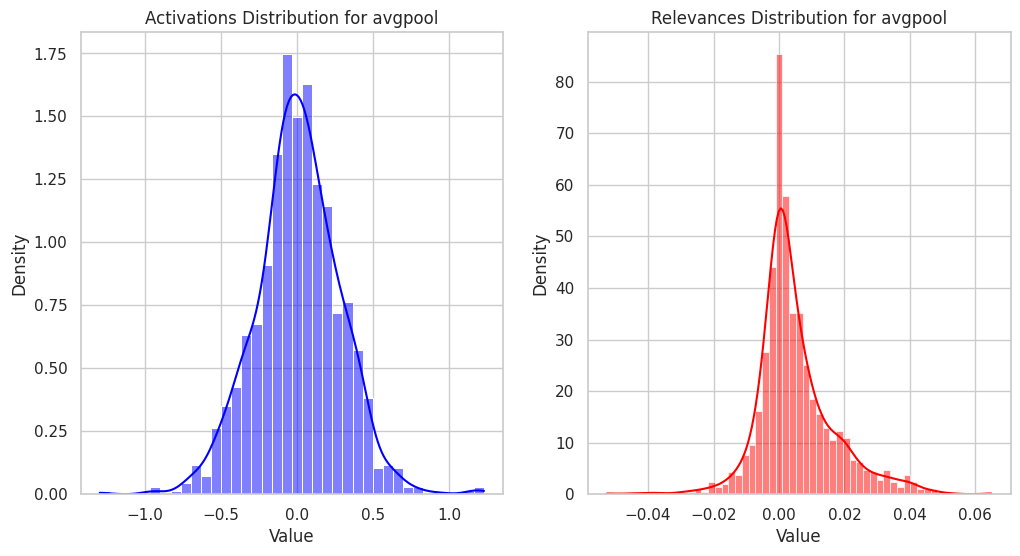

torch.Size([1, 1000]) torch.Size([1, 1000])
Most important feature position in head: 230


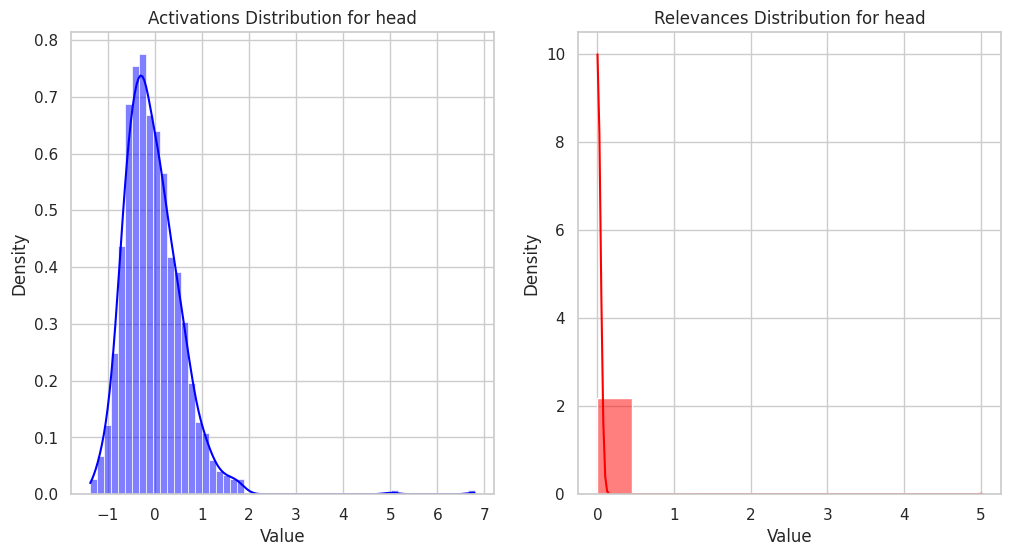

In [14]:
import seaborn as sns
sns.set(style="whitegrid")
for layer in last_layer_names:
    print(attr1.activations[layer].shape, attr1.relevances[layer].shape)
    
    # Flatten the activations and relevances and plot them as a distribution plot one on the left and one on the right
    print(f"Most important feature position in {layer}: {attr1.relevances[layer].argmax().item()}")
    activations_flat = attr1.activations[layer].flatten().cpu().detach().numpy()
    relevances_flat = attr1.relevances[layer].flatten().cpu().detach().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(activations_flat, kde=True, label='Activations', color='blue', stat='density')
    plt.title(f'Activations Distribution for {layer}')
    plt.xlabel('Value')
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)
    sns.histplot(relevances_flat, kde=True, label='Relevances', color='red', stat='density')
    plt.title(f'Relevances Distribution for {layer}')
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Render in the notebook so i can zoom in
    plt.show()
    

Most important features in the last layer values: tensor([0.0649, 0.0524, 0.0477, 0.0467, 0.0461])
Most important features in the last layer indices: tensor([158, 535, 765,  87, 833])


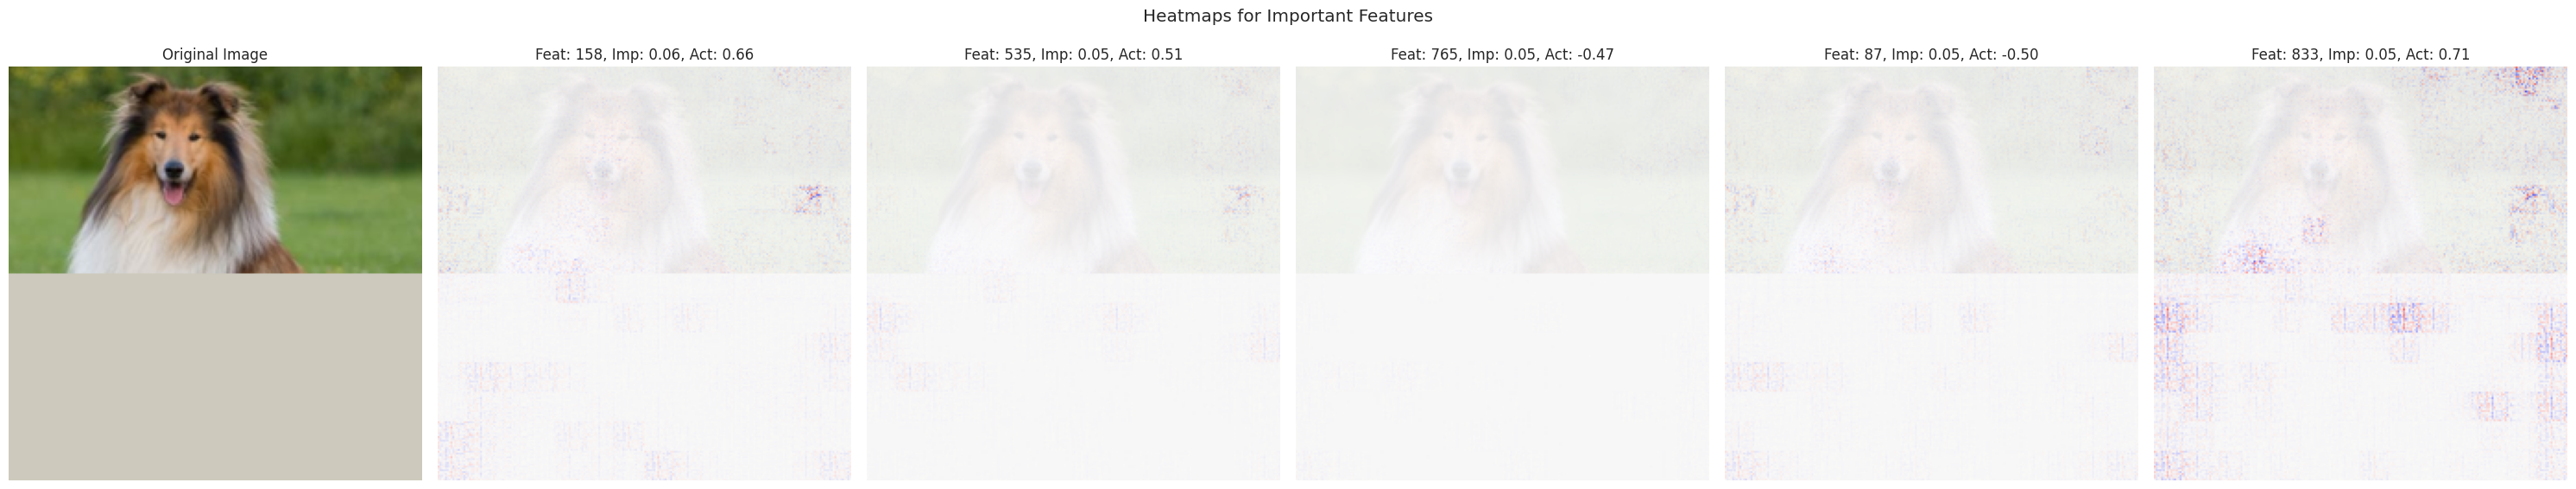

In [15]:
layer = last_layer_names[-2]  
importants = attr1.relevances[layer]

importants = torch.topk(importants,5,dim=1)
# las values y los indices son de la forma (num_features,1,1). Ahora los convertimos a (num_features):
important_val = importants.values.squeeze(0).squeeze(1).squeeze(1)
importants_arg = importants.indices.squeeze(0).squeeze(1).squeeze(1)
print("Most important features in the last layer values:", important_val)
print("Most important features in the last layer indices:", importants_arg)

# condition = [{"y": range(1000), last_layer_names[-2]: [i]} for i in importants]
condition = [{"y": range(1000) , last_layer_names[-2]: [i]} for i in importants_arg]
attr = attribution(sample, condition)
max_abs_val1 = torch.max(torch.abs(attr.heatmap))

# Importances of the last_layer_names[-2]

importances = attr.relevances[last_layer_names[-2]]
activations = attr.activations[last_layer_names[-2]]


# Display the original image and the heatmaps for the important features, the first in the left and one by one on the right

plt.figure(figsize=(30, 6))
heatmaps = attr.heatmap
# heatmap: (5, 224, 224)
# important_val: (5,)
# multiply the heatmaps by the important values

heatmaps = [heatmap * important_val[i]/torch.max(torch.abs(important_val)) for i, heatmap in enumerate(heatmaps)]
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, len(important_val)+1, i + 2)
    img = imgify(heatmap, vmin=-max_abs_val1, vmax=max_abs_val1)
    img = img.resize(image.size, Image.BILINEAR)
    plt.imshow(image)
    plt.imshow(img, alpha=0.9, cmap="jet")
    plt.title(f"Feat: {importants_arg[i]}, Imp: {important_val[i]:.2f}, Act: {torch.sum(activations[i][importants_arg[i]]).item():.2f}")
    plt.axis('off')
    plt.tight_layout()
plt.subplot(1, len(important_val) + 1, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.tight_layout()
plt.suptitle("Heatmaps for Important Features")

plt.tight_layout()

plt.show()

# Intentar aplicar LIME en la obtención de las relevancias y de las activaciones

In [ ]:
from captum.attr import Lime

def forward_feats(model, x):
    """
    Forward pass through the model to get the features.
    """
    # require gradients for the input
    x.requires_grad = True
    composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
    attribution = CondAttribution(model, no_param_grad=True)
    layer_names = get_layer_names(
        model, types=[torch.nn.Conv2d, torch.nn.Linear, torch.nn.AdaptiveAvgPool2d]
    )
    pre_last_layer_name = layer_names[-2]
    attr = attribution(x, [{"y": range(1000)}], composite=composite, record_layer=[pre_last_layer_name])
    feats = attr.activations[pre_last_layer_name]
    # Haz que features en lugar de (1,F,1,1) sea (F,)
    feats = feats.squeeze(0).squeeze(-1).squeeze(-1)  # Remove batch and spatial dimensions
    feats = feats.cpu().detach().numpy()  # Convert to numpy array for display
    return feats

def perturb_func(x, indices):
    """
    Perturb the input image by setting the pixels at the given indices to zero.
    """
    x = x.clone()  # Clone to avoid modifying the original tensor
    for index in indices:
        x[0, index] = 0  # Set the pixel at the index to zero
    return x


lime_atributor = Lime(forward_func=forward_feats,perturb_func=perturb_func)


array([ 0.10061454,  0.23034501,  0.16483703, ..., -0.17136079,
       -0.14809066, -0.22167407], dtype=float32)

TypeError: LimeBase.__init__() got an unexpected keyword argument 'perturbations_per_eval'